# Custom Environment: Intermediate Haunted Mansion
------

Building on the simple environment, I introduced ghosts, candies, and penalties for each timestep where the agent is not at its target location. 

The rules of the environment are as follows with some modifications:

    - The agent can take 4 discrete actions: up, down, left, and right.
    - The game terminates when the agent reaches the exit door of the haunted mansion.
    - The agent represents a trick-or-treater.
    - The agent receives a reward of +20 when they reach the exit door.
    - For each timestep where the agent is not at the target location, they receive a penalty of -0.01 (default is -0.1).
    - If the agent encounters a ghost, they receive a penalty of -25.
    - If the agent encounters a candy, they receive a reward of +15. The reward for each subsequent candy increases by +5 for each candy collected.

I modified the reward structure to ensure optimal training with Q-learning.


## Set Up
-----

In [1]:
import numpy as np
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
from intermediate_env import Intm_Haunted_Mansion
import random

## Defining Custom Environment
----

In [2]:
# Register the environment
gym.register(
    id='Haunted_Mansion-v2',
    entry_point = 'intermediate_env:Intm_Haunted_Mansion'  
)

## Training with PPO
---

In [3]:
# Importing stable baselines 3 for PPO and Wrappers
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecMonitor

In [4]:
# Setting step penalty to 0.2, to discourage and penalise excessive steps
# Large rewards must make penalty higher for ppo
env = gym.make('Haunted_Mansion-v2',  render_mode= None, step_penalty = 0.2)

In [5]:
log_path = ('../../Training/Logs/')

In [6]:
# Create the environment and vectorise it using DummyVecEnv
v_env = DummyVecEnv([lambda: gym.make('Haunted_Mansion-v2', render_mode = None) for i in range(3)])
# Using VecMonitor since have multiple environments
learn_env = VecMonitor(v_env,filename=log_path) 

In [7]:
# Initialise PPO model
# Having to use MultiInputPolicy instead of MlpPolicy since observations are of type dict
model = PPO('MultiInputPolicy', learn_env, verbose=1)

# Train the agent for 100_000 time steps
model.learn(total_timesteps=100_000)

Using cpu device


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.1     |
|    ep_rew_mean     | -270     |
| time/              |          |
|    fps             | 8790     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 6144     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 42.8        |
|    ep_rew_mean          | -108        |
| time/                   |             |
|    fps                  | 5289        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.012678504 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.000211    |
|    learning_rate        | 0.

### Training Logs and Graphs

In [8]:
# Path to monitor.csv file
monitor_file = ('../../Training/Logs/monitor.csv') 

In [9]:
import pandas as pd
# Read the CSV file using pandas
df = pd.read_csv(monitor_file,skiprows=1)

In [10]:
episode_rewards = df['r'].values  # 'r' column contains the reward per episode
episode_lengths = df['l'].values  # 'l' column contains the length of each episode
episode_time = df['t'].values 

In [11]:
# Using moving average to smooth out the noise in both rewards and episode length
smoothed_rewards = pd.Series(episode_rewards).rolling(window=100).mean()
smoothed_length = pd.Series(episode_lengths).rolling(window=100).mean()

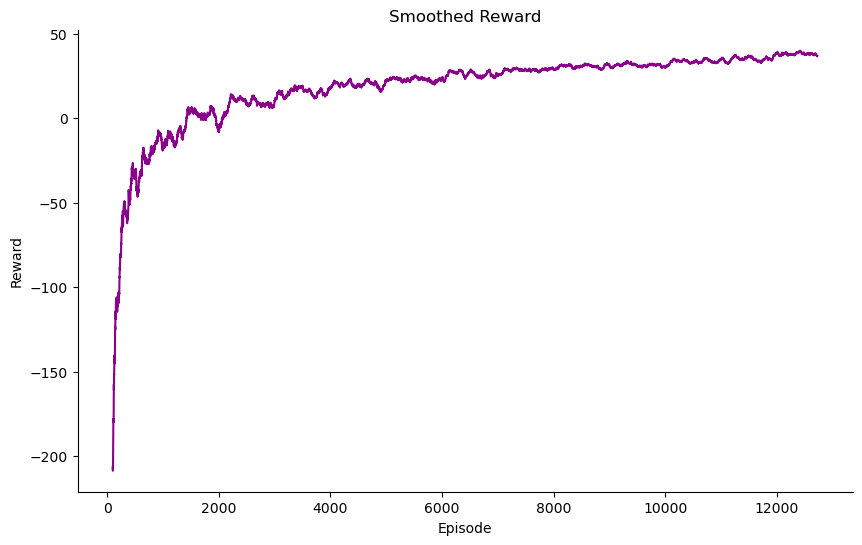

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Reward')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Early in the training, the reward for the first 2000 episdoes vary a lot. This makes sense as this is when the agent is exploring the environment, updating its policy based on its observations. This can be seen by the steep improvement in reward per episode as the policy is updated and the agent starts to exploit the environemnt.

After 3000 episodes, the curve begins to flatten and the rewards start to stabalise around the 40 mark. This is a sign the agent has successfully learned the task well enough and its performance is now stable. After 5000 episodes, the agent's performance no longer improves much suggesting the agent has reached a near optimal policy.

Overall training the agent aligned with typical patterns seen from RL agents. The agent gradually shifts from exploration to exploitation with the learning curve flattening as it reaches a near-optimal policy. 

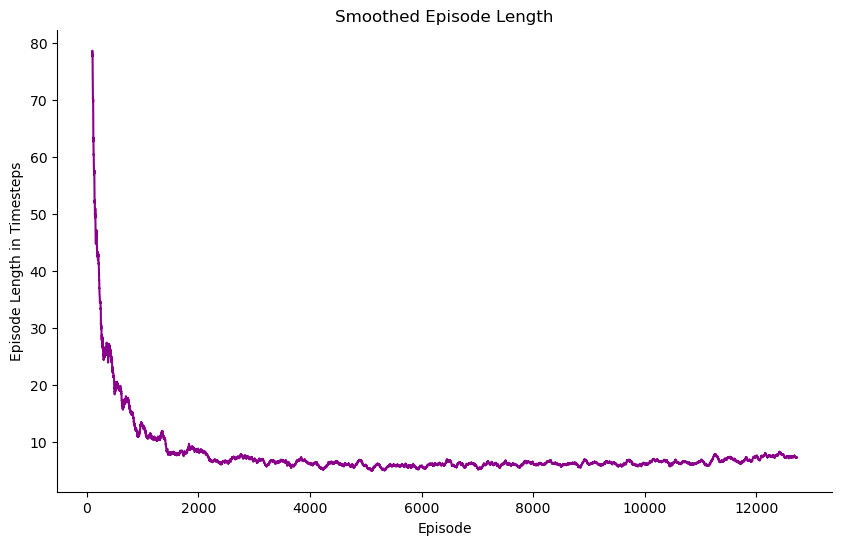

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_length, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Episode Length in Timesteps')
plt.title('Smoothed Episode Length')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

-----
**Comment:**

Early in the training the agent takes a more timesteps to complete the task. This makes sense in RL as early on in the training the agent prioritises exploring its environment taking more timesteps.

As the training progresses, the agent refines its policy and begins to exploit what it has learned, leading to fewer timesteps per episode. The curve beigns to plateau around episode 4000, the agent's policy has become more effective in completing the task, This stability in timesteps suggests the agent has learned a near-optimal path.



### Saving the Model

In [14]:
model.save('../../Training/Saved Models/PPO_intm_haunted_mansion')

### Evaluation

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, learn_env, n_eval_episodes = 10, render = False)

(40.3, 11.700427)

----
**Comment**

**Mean Reward: 40.03**
- Average reward across all ten episodes is greater than 35.
- 20 points is given when the agent reaches the target(door) a further 15 points awarded for each candy collected.
- Successfully performs task in addition to collecting at least one candy along the way and avoiding ghosts

**Standard Deviation: 11.7**
- Shows some variability in the agent's performance across all episodes.
- This could be due to the additional rewards that cause the agent to behave unpredictably at times.

### Testing After Training

In [16]:
env = gym.make('Haunted_Mansion-v2', render_mode = 'human', step_penalty = 0.2)

In [17]:
# Setting the number of episodes for testing
episodes = 15

for episode in range(episodes):
   
    # Resetting the environment to an initial state
    obs, info = env.reset()
    done = False
    score = 0
    
    while not done:
        # Get action from the trained model
        action, _ = model.predict(obs) 
        # Step through the environment using the action
        obs, reward, terminated,truncated, info = env.step(action)  
               
        # Update the done condition based on terminated flag (truncated is always False in this env)
        done = terminated

        # Visualise the environment after each action agent takes
        env.render()

        # Add reward received for action to total episode score
        score += reward
        
        # Delay to slow down the movement for better observation
        pygame.time.delay(350) 
    
    # After the episode ends, print the score
    print(f'Episode {episode + 1} Score: {round(score,2)}')

env.close()

Episode 1 Score: 34.0
Episode 2 Score: 19.8
Episode 3 Score: 33.4
Episode 4 Score: 48.2
Episode 5 Score: 47.4
Episode 6 Score: 48.0
Episode 7 Score: 34.0
Episode 8 Score: 48.2
Episode 9 Score: 48.0
Episode 10 Score: 33.6
Episode 11 Score: 19.4
Episode 12 Score: 33.2
Episode 13 Score: 33.4
Episode 14 Score: 48.2
Episode 15 Score: 33.2


-----
**Comment:**

Overall the agent shows a strong performance with all scores greater than 30 meaning the agent successfully reached the exit door while avoiding ghosts and collecting at least one candy. Also can see that agent's starting position affects whether it decides to collect more candies.

Training with PPO was sufficient in this instance, could be due to the relative simplicity of the environment still. All rewads/penalites in the environemnt are static, only the agent moves. I now progress to training with Q-learning to compare results. 

I could also experiment more in fine tuning the rewards, especially the reward for taking unnecessary steps. Therefore I decided to add the penalty per step as a input paramter on environment init. This makes it easier to experiment with.

## Training with Q-learning
----

### Q-Learning Formula Explanation


The following formula is used to update the Q-values in the Q-table:

$Q_{\text{new}}(s, a) = Q_{\text{old}}(s, a) + \alpha \cdot \left( \text{reward} + \gamma \cdot  \max Q(s', a') - Q_{\text{old}}(s, a) \right)$

------

**Formula Explained:**

-----

- $Q_{\text{new}}(s, a)$
    
    The new Q-value for the state action pair $(s,a)$.
---
- $Q_{\text{old}}(s, a)$
    
    The current (old) Q-value for the state action pair $(s,a)$.
---
- $\alpha$

    The learning rate $\alpha$, controls how much controls how much the agent updates its Q-value. A higher $\alpha$ means the agent will give more weight to the most recent experience, a lower value means the agent will rely more on its past experiences. Values lie between 0 and 1:

    - If $\alpha$ is close to 1, the agent quickly adjusts its Q-values but this could cause instability in learning if set too high.
    - If $\alpha$ is close to 0, the agent updates its Q-values more slowly leading to more stable learning.
---
- $\text{reward}$
    
    Reward the agene receives for taking action a, referred to as immediate reward.
---
- $\gamma$

    The discount factor $\gamma$ controls how much future rewards influence the agent's action selection. Values lie between 0 and 1:

    - If $\gamma$ is close to 1, the agent places more importance on long-term rewards as much as immediate rewards.
    - If $\gamma$ is close to 0, the agent places less importance on long-term rewards and focuses more on immediate rewards.
---

- $\max Q(s', a')$
    
    The maximum Q-value out of all possible actions available from the next state.

    In Q-learning the assumption is made that the agent will choose the best possible action in the future in order to maximise its reward.

    This is where off-policy learning comes in.

----
$\alpha \cdot \left( \text{reward} + \gamma \cdot  \max_{a'} Q(s', a') - Q_{\text{old}}(s, a) \right)$

- We can think of this like an error term, it shows the difference between the new value of Q-value and old Q-value and we use this to update the old Q-value.
    - if the values is positive then this means the current q-value of state s and action a is too low
    - if the values is negative then this means the current q-value of state s and action a is too high

### Implementation Steps:
-----

#### Set Environment

In [38]:
env = gym.make('Haunted_Mansion-v2', render_mode = None, step_penalty = 0.01)

Setting step penalty for Q-learning lower than step penalty for PPO to not discourage exploring. In Q-learning if the agent doesn't explore enough, it can struggle to find optimal path and the Q-values won't be accurate. PPO is a more stable training method and so can cope with a higher step penalty.

#### Initialising Q-table

In [39]:
# Number of potential states, since agent is only moving = 5*5
nr_states = 25
# Number of actions the agent can take (action_space)
nr_actions = 4
# Initialise the Q-Table with zeros, of shape nr_states and nr_actions
q_table = np.zeros([nr_states,nr_actions], dtype= float)

In [40]:
import pandas as pd

# Meaningful state representation - all possible grid coordinates
all_states  = []
for i in range(5):
    for j in range(5):
        states = (i,j)
        all_states.append(states)

# Make states the index, using MultiIndex as dealing with coordinates (x,y)
index = pd.MultiIndex.from_tuples(all_states, names=['x', 'y'])

In [41]:
# Turning to df for easier manipulation, columns represent the actions
df_q_table = pd.DataFrame(q_table, index = index, columns=[0, 1, 2, 3])

In [42]:
# Quick check of df
df_q_table

0    1    2    3
x y                    
0 0  0.0  0.0  0.0  0.0
  1  0.0  0.0  0.0  0.0
  2  0.0  0.0  0.0  0.0
  3  0.0  0.0  0.0  0.0
  4  0.0  0.0  0.0  0.0
1 0  0.0  0.0  0.0  0.0
  1  0.0  0.0  0.0  0.0
  2  0.0  0.0  0.0  0.0
  3  0.0  0.0  0.0  0.0
  4  0.0  0.0  0.0  0.0
2 0  0.0  0.0  0.0  0.0
  1  0.0  0.0  0.0  0.0
  2  0.0  0.0  0.0  0.0
  3  0.0  0.0  0.0  0.0
  4  0.0  0.0  0.0  0.0
3 0  0.0  0.0  0.0  0.0
  1  0.0  0.0  0.0  0.0
  2  0.0  0.0  0.0  0.0
  3  0.0  0.0  0.0  0.0
  4  0.0  0.0  0.0  0.0
4 0  0.0  0.0  0.0  0.0
  1  0.0  0.0  0.0  0.0
  2  0.0  0.0  0.0  0.0
  3  0.0  0.0  0.0  0.0
  4  0.0  0.0  0.0  0.0

#### Define Parameters

In [43]:
learning_rate = 0.05
discount_factor = 0.99
epsilon = 1.0

-----
**Comment:**

Reasons for selecting these values:

1. $\alpha$ : Learning Rate

- Initially started with a high learning rate of 0.1 but this caused some instability.
- Large updates to the Q-values hindered learning, I then set the learning rate to 0.05 to make learning more stable.

2. $\gamma$ : Discount Factor

- Set to 0.99 to ensure that future rewards are considered in the agent's decision making.

3. $\epsilon$ : Epsilon

- Consider this to be an exploration probability.
- Initially set to 1, ensuring the agent explores its environment fully in the early episodes.
- Over episodes, epsilon decays to encourage exploitation of previous experiences.
- Capped decay to 0.01 to ensure the agent still randomly explores and continues to search for optimal paths to max rewards.

#### Updating Q Values

In [44]:
# Training over 100,000 episodes
episodes = 100_000
# Saving rewards per epsiode to list
rewards_per_episode = []

for episode in range(episodes):
    
    # Get initial obs from env
    obs, info = env.reset()
    # Initialise score to 0 for each episode
    score = 0
    # Initialise done to False for each episode
    done = False
    # Get current state of agent, (Agent's grid coordinates)
    # Using tuple to return a tuple instead of array
    current_state = tuple(obs['agent'])
    
    while not done:
        # Generate random number between 0 and 1
        rand_num = random.random()
        # Use rand_num to control exploration/exploitation
        if rand_num < epsilon:
            # Select random action - exploration
            action = env.action_space.sample()  
        else:
            # Select action with max q-value for current state - Exploration
            action = df_q_table.loc[current_state].idxmax()  
        
        # Use step to take action
        obs, reward, terminated, truncated, info = env.step(action)
        # Set next_state from step returns
        next_state = tuple(obs['agent'])
        
        # Getting max q-value from next_state
        max_future_q = df_q_table.loc[next_state].max()  
        # Get current q_value for state and action
        current_q_value = df_q_table.loc[(current_state, action)]  
        
        # Using Q-learning formula
        error = learning_rate * (reward + discount_factor * max_future_q - current_q_value)
        # Updating Q-table
        df_q_table.loc[(current_state, action)] = df_q_table.loc[(current_state, action)]  + error 
   
        score += reward
        # Setting current_state to next_state once update is done 
        current_state = next_state
        # Done only True once Terminated is True (agent reaches door)
        done = terminated 
    # Decay epsilon across all episodes 
    # Using max to avoid epsilon decaying all the way to 0
    epsilon = max(0.01, 1 - (episode / episodes))
    # Adding total score to list
    rewards_per_episode.append(score)

    print(f'Episode: {episode + 1}, Score: {score}')

Episode: 1, Score: -426.69999999999953
Episode: 2, Score: -30.060000000000006
Episode: 3, Score: -251.35999999999893
Episode: 4, Score: -25.62000000000003
Episode: 5, Score: -90.66000000000008
Episode: 6, Score: -315.7499999999999
Episode: 7, Score: -100.91000000000012
Episode: 8, Score: -551.7799999999987
Episode: 9, Score: 49.68
Episode: 10, Score: -155.33000000000007
Episode: 11, Score: -251.33999999999912
Episode: 12, Score: -300.51999999999964
Episode: 13, Score: 19.99
Episode: 14, Score: 19.99
Episode: 15, Score: -125.46000000000002
Episode: 16, Score: -115.51000000000009
Episode: 17, Score: -752.8299999999979
Episode: 18, Score: 9.8
Episode: 19, Score: -490.8299999999995
Episode: 20, Score: -326.13999999999953
Episode: 21, Score: 19.979999999999997
Episode: 22, Score: -416.01999999999936
Episode: 23, Score: -165.31000000000003
Episode: 24, Score: -115.37000000000005
Episode: 25, Score: -155.3999999999999
Episode: 26, Score: -75.84000000000003
Episode: 27, Score: -15.399999999999

#### Evaluate

In [45]:
# Storing scores as df
scores = pd.DataFrame(rewards_per_episode, columns= ['reward'])

In [46]:
smoothed_rewards = pd.Series(scores['reward']).rolling(window=100).mean()

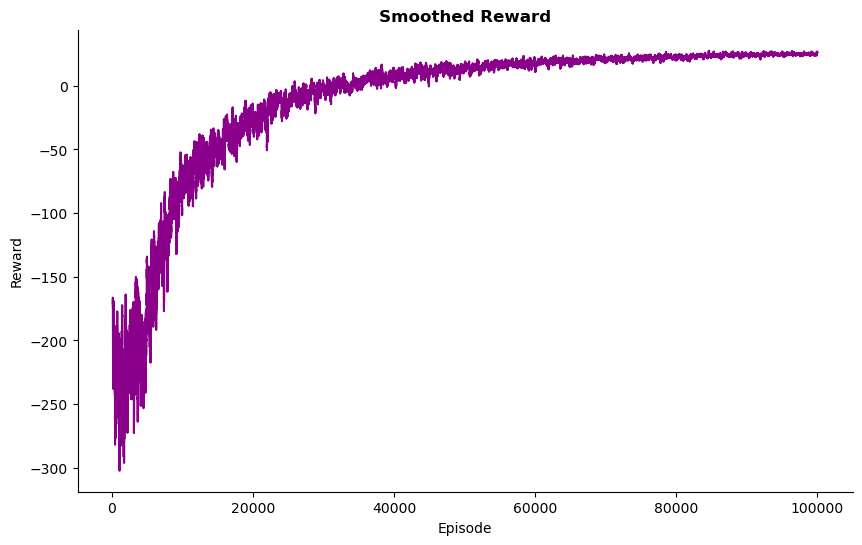

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards, color='darkmagenta')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed Reward',fontweight = 'bold')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

----
**Comment:**

Overall, the trend shows an improvement in the agent’s performance across episodes as training progresses. This is likely due to the shift from exploration to exploitation as epsilon decays. Early in training, the agent explores randomly, leading to high variability in rewards and large penalties. As training progresses, the agent starts exploiting its learned Q-values, resulting in higher rewards. Towards the end of training, the agent’s performance starts to plateau as fewer updates are made to the Q-table, and it begins to converge.

Despite these improvements, there is still significant noise throughout training. While the rewards stabilise over time, they never fully smooth out. This is likely because epsilon is never fully decayed, meaning the agent continues to take some random actions, introducing variability.

PPO appears to be much more stable. This may be due updates it makes to its policy after each episode. This results in smoother reward curves, as learning is more gradual.

Q-learning needs more episodes to train which is expected since it makes more frequent updates, PPO makes less regular updates so is quicker to converge.


#### Testing

In [53]:
env = gym.make('Haunted_Mansion-v2', render_mode = 'human', step_penalty= 0.01)

In [54]:
# Setting the number of episodes for testing
episodes = 20

for episode in range(episodes):
   
    # Resetting the environment to an initial state
    obs, info= env.reset()

    done = False

    score = 0
    
    while not done:
        # Get action from the Q-table
        action = df_q_table.loc[tuple(obs['agent'])].idxmax()
        
        # Step through the environment using the action
        obs, reward, terminated,truncated, info = env.step(action)  
               
        # Update the done condition based on terminated flag (truncated is always False in this env)
        done = terminated

        # Visualise the environment after each action agent takes
        env.render()

        # Add reward received for action to total episode score
        score += reward
        
        # Delay to slow down the movement for better observation
        pygame.time.delay(600) 
    
    # After the episode ends, print the score
    print(f'Episode {episode+1} Score: {round(score,2)}')

env.close()

Episode 1 Score: 19.99


Episode 2 Score: 34.94
Episode 3 Score: 34.95
Episode 4 Score: 34.94
Episode 5 Score: 19.96
Episode 6 Score: 34.95
Episode 7 Score: 19.98
Episode 8 Score: 34.94
Episode 9 Score: 19.97
Episode 10 Score: 19.94
Episode 11 Score: 34.93
Episode 12 Score: 19.95
Episode 13 Score: 34.94
Episode 14 Score: 19.98
Episode 15 Score: 34.95
Episode 16 Score: 19.98
Episode 17 Score: 34.94
Episode 18 Score: 34.94
Episode 19 Score: 19.94
Episode 20 Score: 19.94


-----
**Comment:**

By comparing the Q-learning test results to the PPO test results it is clear PPO has outperformed Q-learning. This could be as:

- PPO updates the policy based on what the agent observes over an episode, gradually adjustiong the poilicy using clipping to avoid drastic changes in policy. This is why we see the learning is more smooth with PPO.

- Q-learning does not have a policy to update, it updates values which represent estimates of 'goodness' an action is depending on states of environment. These updates occur after each action which is probably why the results from training are so volatile and learning is less stable.

- Q-learning needs more episodes in order to explore all possible state-action pairs in the Q-table, PPO does not need to explore as much.

- Q-learning also requires epsilon-greedy methods for action selection which can be quite noisy, PPO uses probabilities for updates which are less nosiy.


In [50]:
# rename columns for one off view, easier to interpret
df_q_table.rename(columns = {0:'right', 1:'down', 2:'left', 3:'up'})

right        down        left          up
x y                                                
0 0  868.948505  801.713118  788.139236  775.397908
  1  878.050514  817.312714  802.145500  779.661864
  2  888.168911  815.579343  828.079372  809.865236
  3  881.940608  799.157026  804.573570  810.873803
  4  872.664834  795.715265  802.332308  808.016983
1 0  879.457904  837.735528  788.837746  837.958433
  1  850.329095  888.646618  834.261407  833.916278
  2  898.339397  853.946836  851.868359  844.924496
  3  892.314672  847.313511  845.672361  863.640215
  4  826.755382  833.318023  816.587151  882.851914
2 0  889.013584  852.770221  836.772617  844.737672
  1  829.508097  896.996317  824.613841  826.097483
  2  892.545410  866.629807  865.555597  861.344995
  3  901.587616  853.005231  856.767189  871.075641
  4  909.436879  830.381987  822.648928  846.149747
3 0  850.587517  883.310686  851.899892  847.641661
  1  851.459695  892.505529  868.825547  860.689521
  2  862.197133  901.773882  879.004504  869.598686
  3  897.150130  911.086275  881.634694  883.229472
  4  920.452735  901.876677  866.197932  891.033779
4 0  814.447182  819.636694  887.955279  820.563501
  1  814.995657  820.727337  882.425660  820.630816
  2  825.698628  908.930945  845.201922  830.588101
  3  870.760765  919.599819  861.267063  839.077761
  4  857.407713  837.721308  909.630371  809.653754

----
**Comment:**

The Q-table reflects the agent’s learned action values for each state in the grid. Let's see if the agent has found the rewards well by looking at cells surrounding the rewards:

Remember the grid layout: (0,0) is in the top-left corner, and the bottom-right is (4,4). Down increases the y-coordinate, and up decreases the y-coordinate.

**(4, 4) Exit Door [+20]**

Surrounding cells:

    (4,3): The highest Q-value is for the action Down. This makes sense, as moving down to (4,4) is where the reward is.
    (3,4): The highest Q-value in the row is for the Right action, as expected when the reward is at (4,4).

**(4, 2) Ghost 1 [-25]**

Surrounding cells:

    (4,1): The highest Q-value is for the Left action. The agent has successfully learned to take a step to the left to avoid the ghost.
    (3,2): The highest Q-value is for the Down action towards the exit door.
    (4,3): Already discussed – see (4,4) Exit Door ^

**(2, 4) Ghost 2 [-25]**

Surrounding cells:

    (1,4): The highest Q-value is for the Up action. The agent has successfully learned to take a step to avoid the ghost.
    (2,3): The highest Q-value is for the Left action towards the exit door.
    (3,4): Already discussed – see (4,4) Exit Door ^

**(2, 2) Candy 1 [+15]**

Surrounding cells:

    (2,1): The highest Q-value is for the Down action. The agent has successfully learned to collect the candy from this state.
    (1,2): The highest Q-value is for the Right action. The agent has successfully learned to collect the candy from this state.
    (3,2): The agent seems to look ahead and favor future rewards, as the highest Q-value is Down towards the door.
    (2,3): The highest Q-value is for Right. The agent favors the future reward and goes towards the door; the second-highest Q-value is Up towards the candy.

**(3, 0) Candy 2 [+15]**

Surrounding cells:

    (2,0): The highest Q-value is for Down. The agent favors future rewards and goes towards the door. The second-highest Q-value is Right towards the candy.
    (4,0): The highest Q-value is for the Left action. The agent has successfully learned to collect the candy from this state.
    (3,1): The highest Q-value is for the Down action. The agent avoids the candy as it prioritizes reaching the exit door.




## Summary
-----

From observing the agent in the environment post-training, the agent is performing as expected. The main objective is to reach the exit door and avoid the ghosts. If there are candies on the way, the agent should collect them but the main priority is to reach the exit door.  